## Main trends between density class and citation rates from paper

#### Imports

In [2]:
import scipy
import pandas as pd
import plotnine as pn
import numpy as np

import matplotlib.pyplot as plt
import warnings
import matplotlib.gridspec as gridspec


from tqdm import tqdm



#### Configs

In [3]:
vectorizer = "SciBERT"
num_quantiles = 100

#### Load data

In [4]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,1545.550332,0.814415,42,2.250000,False,2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f,2004,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
1,1846.261870,0.452021,88,4.625000,False,d7b6cd39dd111afa55a3aa418b7b5459db12988d,2012,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
2,1703.520959,0.490212,30,0.882353,False,2d62ec65f95435c72ef750b3cff331382c5dca92,2003,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
3,1901.386693,0.715160,95,8.166667,False,8cebc6e3dcfb543bad48d89112e281a6e11c33c2,2014,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
4,535.472125,0.885892,94,2.090909,False,59730a4bae4dc53f59341b63fd1e63451c589e9f,2009,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
537685,48.730838,0.658585,41,3.500000,False,806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24,2018,S2,SciBERT,Andre2018,Mathematics
537686,25.107589,0.721374,38,3.200000,False,f40707d1165c22e185c25e6837977177ee380f2c,2015,S2,SciBERT,Andre2018,Mathematics
537687,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
537688,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics


In [5]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all['log_cpy'] = df_all['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


In [6]:
field_names = sorted(df_all["fields_of_study_0"].unique())
field_names

['Economics',
 'Education',
 'Geology',
 'Linguistics',
 'Materials Science',
 'Mathematics',
 'Medicine',
 'Philosophy',
 'Physics']

In [7]:
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

Filter

In [8]:
df = df_all[df_all["vectorizer"] == vectorizer]

Transform

#### Bin measurements

In [9]:
# Helper function for z-scaling
def zscale(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
    result = (df_in[col] - np.nanmean(df_in[col])) / np.nanstd(df_in[col])
    return result

In [10]:
def bin_measurements(df_in: pd.DataFrame, field: str, num_quantiles: int) -> pd.DataFrame:
    """Given a dataframe and a field to subset to, cut density observations into `num_bins` and compute statistics of the resulting citation distribution induced by the density class."""

    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # Filter within reasonable values
    # First get z-scales for density and citation rates
    for col in ["density", "citations_per_year"]:
        df[f"{col}_z"] = zscale(df, col)

    # For density bin
    density_bin_max = df["density_z"] < 3
    density_bin_min = df["density_z"] > -3
    # For cpy
    cpy_max = df["citations_per_year_z"] < 3
    cpy_min = df["citations_per_year_z"] > -3
    # Apply masks
    df = df[density_bin_max & density_bin_min & cpy_max & cpy_min]

    # Cut into quantiles
    df["density_bin"] = pd.qcut(
        df["density"],
        q=num_quantiles,
    )

    # Group data after binning
    data_bins = df[["log_cpy", "density_bin", "citations_per_year", "references", "year"]]

    # Measure statistics
    statistics = []
    for bin_key in sorted(df.density_bin.value_counts().keys()):
        df_bin = data_bins[data_bins["density_bin"] == bin_key]
        statistics.append((
            np.nanvar(df_bin["log_cpy"].values),
            np.nanmedian(df_bin["citations_per_year"].values),
            np.nanmedian(df_bin["references"].values),
            np.nanmedian(df_bin["year"].values),
        ))
    
    # Construct dataframe
    df_result = pd.DataFrame(
        statistics,
        columns=[
            "log_cpy_var",
            "cpy_med",
            "ref_med",
            "year_med",
        ],
    )

    # Annotate by (start of) density bin
    df_result["density_bin"] = [float(item.left) for item in df.density_bin.value_counts(sort=False, normalize=True).keys()]

    # Annotate z-scales for density and citation rates
    for col in ["density_bin", "cpy_med", "ref_med", "year_med"]:
        col_z = f"{col}_z"
        df_result[col_z] = zscale(df_result, col)
        
    # Annotate counts and relative frequencies
    df_result["counts"] = df.density_bin.value_counts(sort=False, normalize=False).tolist()
    df_result["freq"] = df.density_bin.value_counts(sort=False, normalize=True).tolist()
    # Annotate field
    df_result["field"] = field

    return df_result

In [11]:
# Sanity check to make sure all frequencies are close, thus controlling for this variable.
bin_measurements(df, "Physics", 1000).counts.value_counts()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/1179796159.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/1179796159.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


counts
11    964
10     28
12      6
13      1
9       1
Name: count, dtype: int64

In [12]:
df_binned_all = pd.concat(
    [bin_measurements(df, field, num_quantiles)
    for field in field_names],
)
df_binned_all.head()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/1179796159.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/1179796159.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/1179796159.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,log_cpy_var,cpy_med,ref_med,year_med,density_bin,density_bin_z,cpy_med_z,ref_med_z,year_med_z,counts,freq,field
0,0.442514,0.226496,41.0,2008.0,18.082,-2.986470,-2.046489,2.800282,-1.607820,150,0.010064,Economics
1,0.562017,0.300000,29.0,2009.0,22.280,-2.234323,-1.754169,-1.302695,-0.577166,149,0.009997,Economics
2,0.564395,0.333333,28.0,2008.0,23.878,-1.948012,-1.621605,-1.644610,-1.607820,149,0.009997,Economics
3,0.506010,0.562500,27.0,2008.0,24.859,-1.772248,-0.710230,-1.986525,-1.607820,149,0.009997,Economics
4,0.470341,0.375000,27.0,2008.0,25.470,-1.662776,-1.455901,-1.986525,-1.607820,149,0.009997,Economics


## Main linear trends

In [13]:
df_plot = df_binned_all.copy()

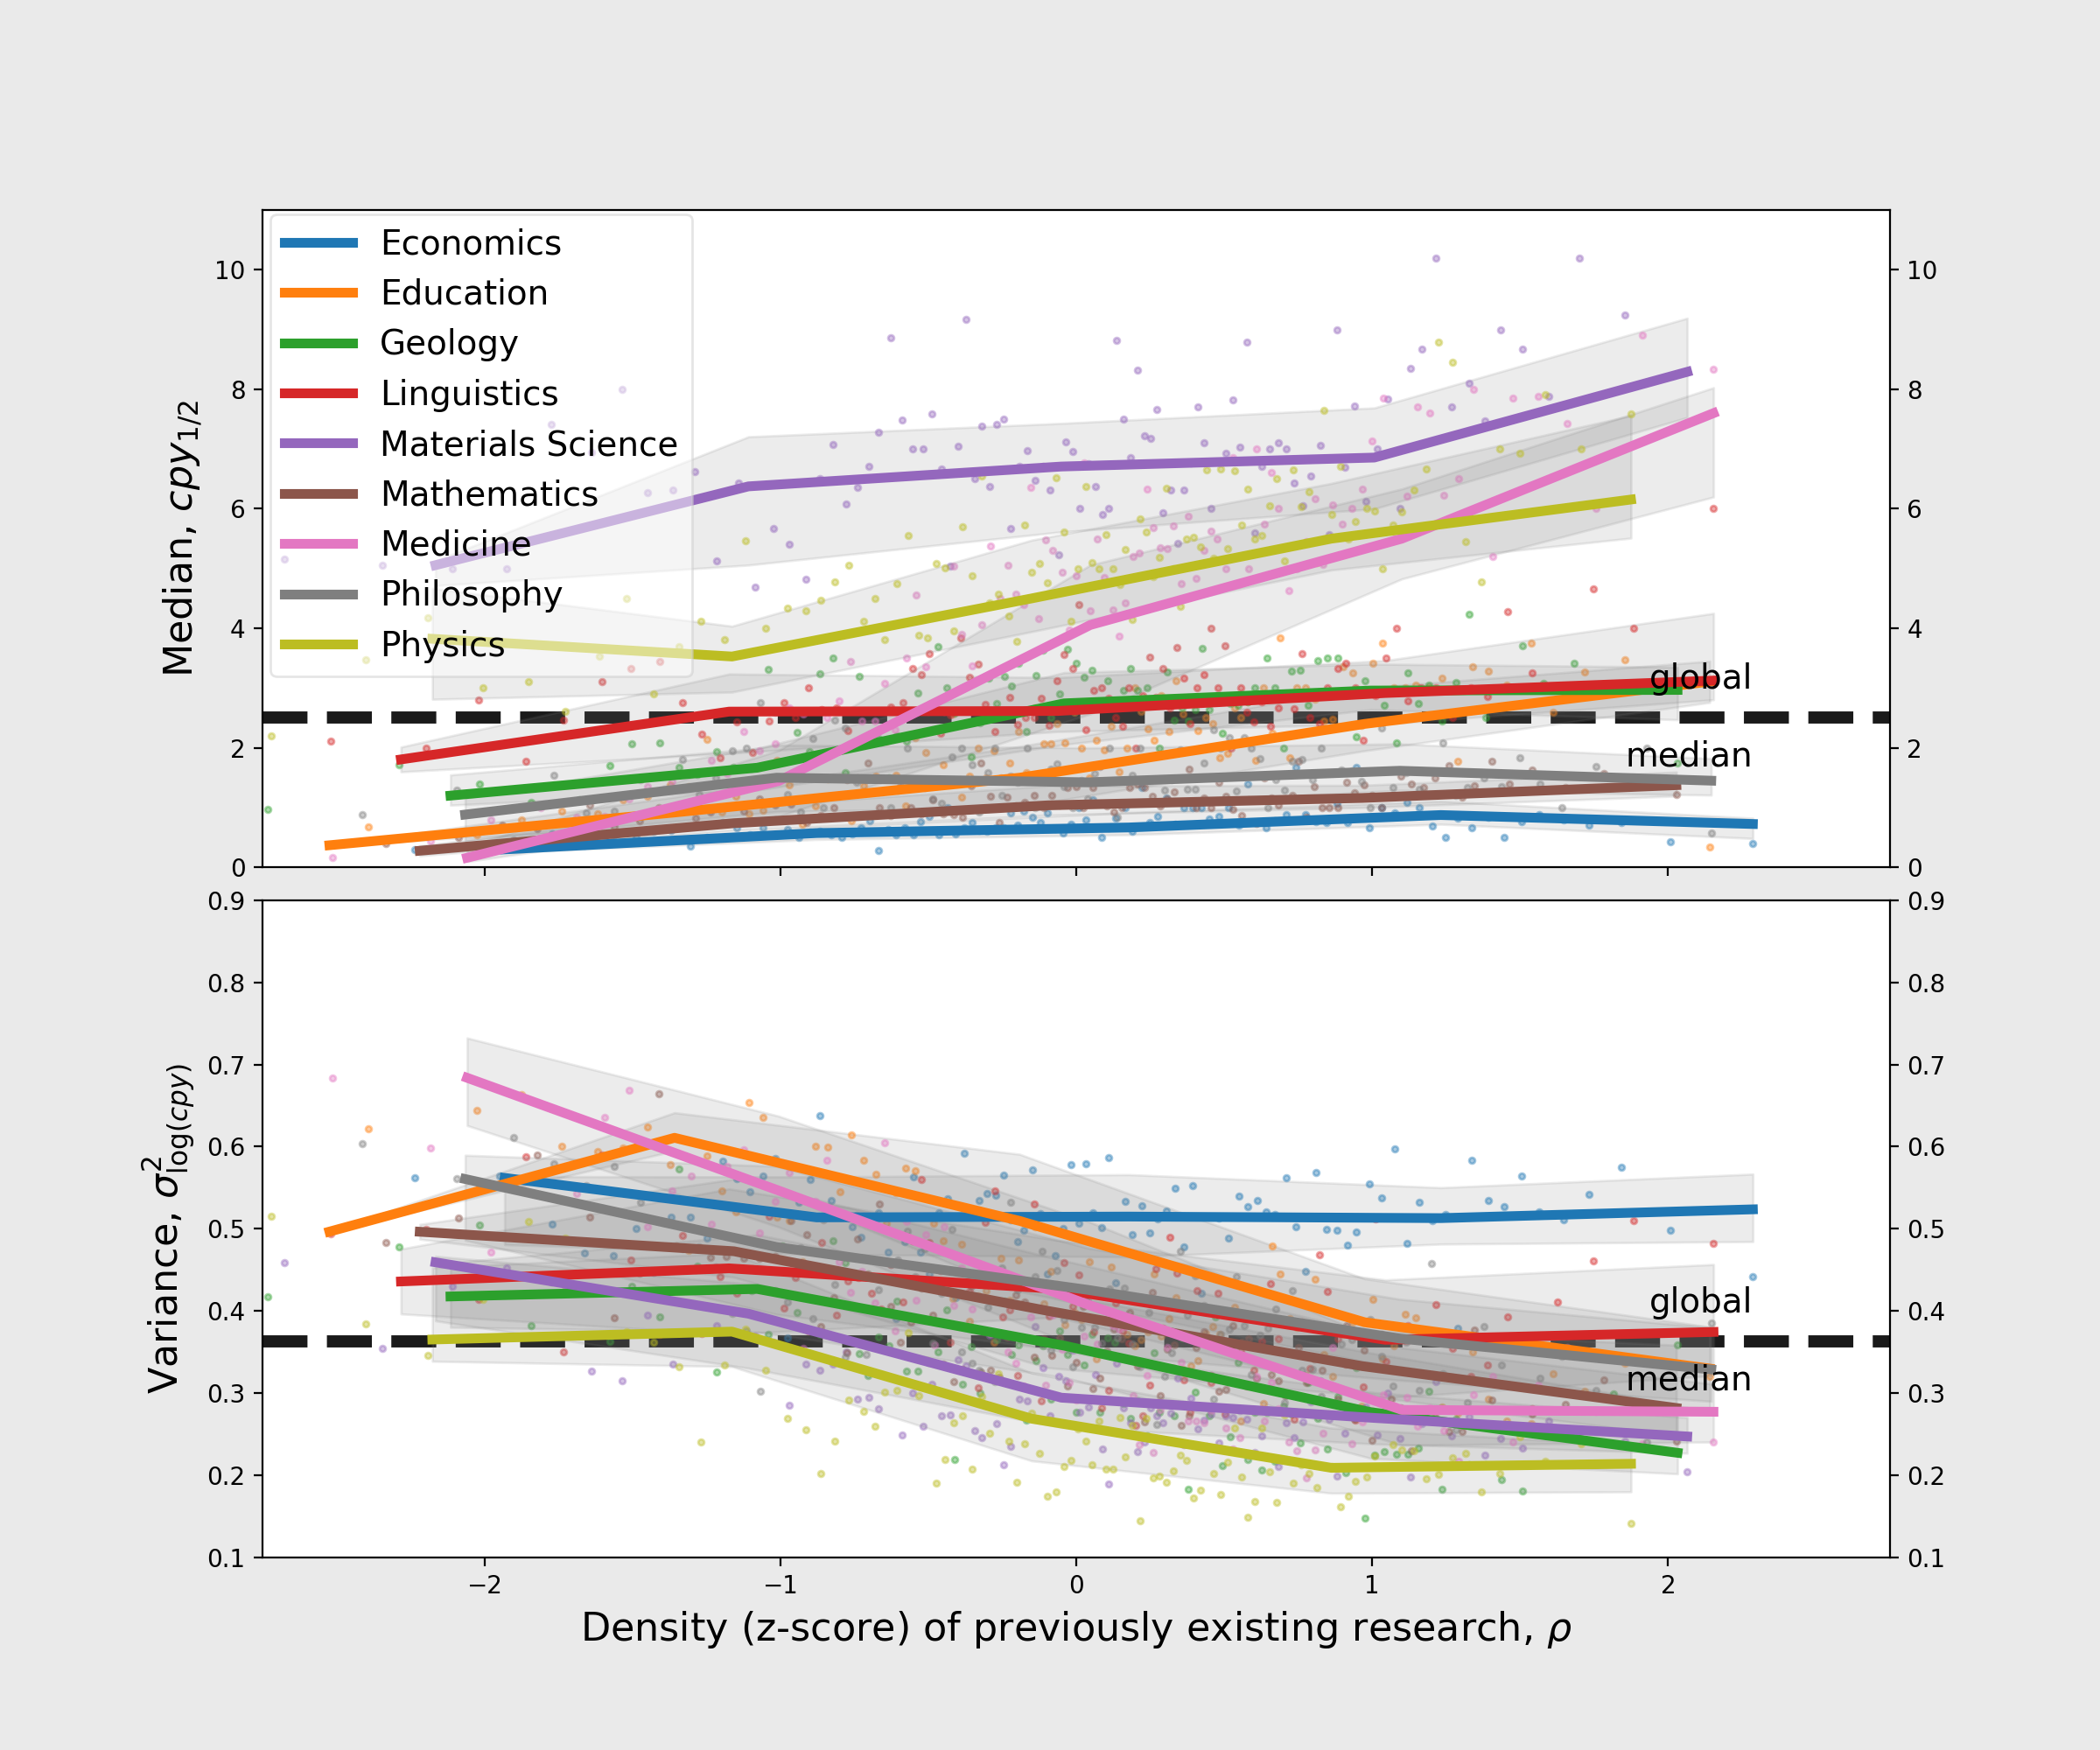

In [57]:

rows = ["median", "variance"]
n_rows = 2

facecolor = np.array([ 235, 235, 235 ]) / 256.
fig = plt.figure( figsize=(12, 5*n_rows), facecolor=facecolor )

gs = gridspec.GridSpec( n_rows, 1 )
gs.update( hspace=0.05, wspace=0.001 )


x_variable = "density_bin_z"
y_variable_maps = {
    "median": "cpy_med",
    "variance": "log_cpy_var",
}

# For each trend
for row_idx, row in enumerate(rows):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.subplot( gs[row_idx,0],  )

    y_variable = y_variable_maps[row]
    x_observations = df_plot[x_variable]
    y_observations = df_plot[y_variable]

    # N.B.: global scatter, median, percentiles not really well formed across fields, since citation rates are field specific.

    # GLobal

    bin_edges = np.linspace(
        x_observations.min(),
        x_observations.max(),
        10,
    )

    xs = bin_edges[:-1] + 0.33 * ( bin_edges[1] - bin_edges[0] )

    # # Binned median
    # median, bin_edges, _ = scipy.stats.binned_statistic( x_observations, y_observations, 'median', bins=bin_edges )
    # ax.plot(
    #     xs,
    #     median,
    #     linewidth = 10,
    #     color = "black",
    # )


    # Global median number of citations (baseline)
    global_median = np.nanpercentile( y_observations, 50. )
    ax.axhline(
        global_median,
        color = '0.1',
        linestyle = '--',
        linewidth = 5,
        zorder = -100,
    )
    ax.annotate(
        text = 'global\n\nmedian',
        xy = (bin_edges[-1], global_median),
        xycoords = 'data',
        xytext = (0, 0),
        textcoords = 'offset points',
        va = 'center',
        ha = 'right',
        fontsize = 14,
    )    


    #######################################
    # Fields
    #######################################      

    fields = df_binned_all.field.unique()
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    for i, field in enumerate(fields):

        df_vectorizer = df_plot[df_plot["field"] == field]

        x_observations_field = df_vectorizer[x_variable]
        y_observations_field = df_vectorizer[y_variable]

        bin_edges = np.linspace(
            x_observations_field.min(),
            x_observations_field.max(),
            6,
        )

        xs = bin_edges[1:]

        # Binned median
        median, bin_edges, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, 'median', bins=bin_edges )
        upper_fn = lambda y: np.nanpercentile( y, 84 )
        upper, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, upper_fn, bins=bin_edges )
        lower_fn = lambda y: np.nanpercentile( y, 16 )
        lower, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, lower_fn, bins=bin_edges )
        ax.fill_between(
            xs,
            lower,
            upper,
            color = "gray",
            alpha = 0.15,
        )

        ax.scatter(
            x_observations_field,
            y_observations_field,
            alpha = 0.4,
            s=6,
            # label=field,
        )    

        ax.plot(
            xs,
            median,
            linewidth = 4,
            label = field,
        )

    #######################################
    # Label rows
    #######################################      
    if row == "median":
        # ax.set_yscale( 'log' )
        ax.set_ylim(0,11)
        # ax.set_xlim(12,25) 
        ax.set_xlim(-2.75,2.75)
        
        ax.set_ylabel( r'Median, ${cpy}_{1/2}$', fontsize=16 )

    if row == "variance":
        # ax.set_yscale( 'log' )
        ax.set_ylim(0.1, 0.9,)
        # ax.set_xlim(12,25)
        ax.set_xlim(-2.75,2.75)        

        ax.set_ylabel( r'Variance, $\sigma_{\log(cpy)}^2$', fontsize=16 )

    # Customize ticks
    # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
    # ax.tick_params( which='minor', direction='in', size=5, width=2, )
    ax.tick_params( right=True, labelright=True )
    if not ax.get_subplotspec().is_last_row():
        ax.tick_params( axis='x', labelbottom=False )

axbox = ax.get_position()
ax.legend(
    prop = {'size': 14, },
    ncol = 1,
    # loc = 'upper right',
    loc = (axbox.x0 + -0.12, axbox.y0 + 1.23),
    # loc = (axbox.x0 + 0.6, axbox.y0 + 1.23),
    # title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)


# ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=16 )
ax.set_xlabel( r'Density (z-score) of previously existing research, $\rho$', fontsize=16 )


# plt.tight_layout()

plt.show()


## Violins faceted by field

In [15]:
import seaborn as sns
import matplotlib.transforms
from matplotlib import patheffects

In [16]:
# Set density classes to compare by quantile
metric_quantile = 0.25
metric_percent = int(100 * metric_quantile)

Transform data

In [17]:
dfs_field_quantiles = []
for field in field_names:
    df_field = df[df["fields_of_study_0"] == field]

    # Create density categories
    upper_quantile = df_field['density'].quantile(1 - metric_quantile)
    lower_quantile = df_field['density'].quantile(metric_quantile)
    df_field['density_cat'] = 'center'
    df_field.loc[df_field['density'] < lower_quantile, 'density_cat'] = f'lower {metric_percent}%'
    df_field.loc[df_field['density'] > upper_quantile, 'density_cat'] = f'upper {metric_percent}%'
    df_field = df_field.loc[df_field['density_cat'] != 'center']
    df_field['density_cat'] = df_field['density_cat'].astype('category')

    # Annotate field
    df_field['field'] = field

    dfs_field_quantiles.append(df_field)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/465044166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/465044166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/465044166.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [18]:
# Combine
df_quantiles = pd.concat(dfs_field_quantiles)

# Correct duplicates 
print(len(df_quantiles[df_quantiles.index.duplicated()]))
df_quantiles = df_quantiles.reset_index()
print(len(df_quantiles[df_quantiles.index.duplicated()]))

0
0


/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/2503391710.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Median fraction change: 1.29
Median std fraction change: 0.71



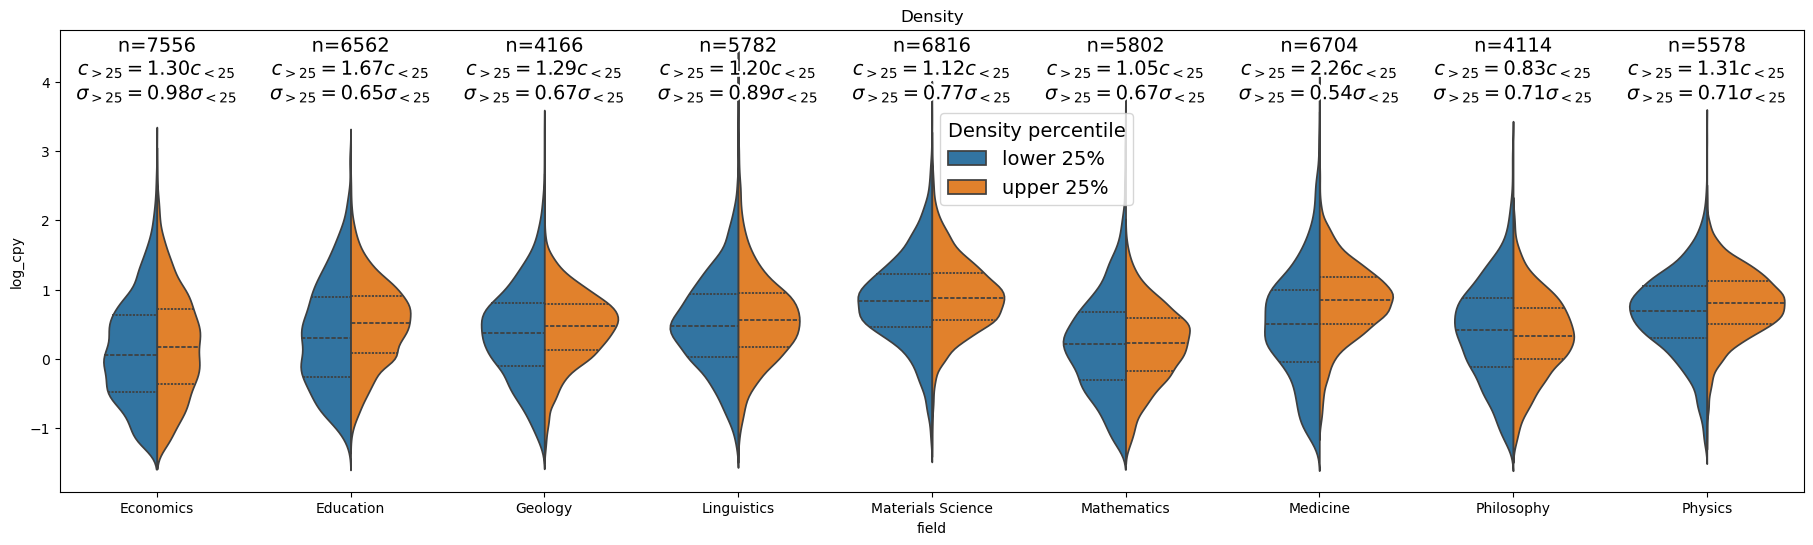

In [19]:

fig = plt.figure(figsize=(len(field_names) * 2.5, 6))
ax = plt.gca()
ax.set_title("Density")

sns.violinplot(
    ax=ax,
    data=df_quantiles,
    # x='center',
    x='field',
    y='log_cpy',
    # y='citations_per_year',
    hue='density_cat',
    # palette='mako',
    split=True,
    inner='quart',
    dodge=True,
    gap=0,
)

df_by_field = df_quantiles.groupby('field')
fraction_changes = []
fraction_std_changes = []
for i, key in enumerate(field_names):

    # Get the group
    df_field = df_by_field.get_group(key)
    n = df_field.shape[0]

    # Median change
    df_field_by_density = df_field.groupby('density_cat')
    med_cpy = 10.**df_field_by_density['log_cpy'].median()
    fraction_change = med_cpy[f'upper {metric_percent}%'] / med_cpy[f'lower {metric_percent}%']
    fraction_changes.append(fraction_change)
    median_change_str = (
        fr'$c_{{>{metric_percent}}} = '
        f'{fraction_change:.2f}'
        fr'c_{{<{metric_percent}}}$'
    )

    # Median change in width
    std_cpy = 10.**df_field_by_density['log_cpy'].std()
    fraction_std_change =  std_cpy[f'upper {metric_percent}%'] / std_cpy[f'lower {metric_percent}%']
    fraction_std_changes.append(fraction_std_change)
    std_change_str = (
        fr'$\sigma_{{>{metric_percent}}} = '
        f'{fraction_std_change:.2f}'
        fr'\sigma_{{<{metric_percent}}}$'
    )

    text = ax.annotate(
        text=f'n={n}\n' + median_change_str + '\n' + std_change_str,
        xy=(i, 1),
        xycoords=matplotlib.transforms.blended_transform_factory(
            ax.transData,
            ax.transAxes,
        ),
        xytext=(0, -5),
        textcoords='offset points',
        ha='center',
        va='top',
        fontsize=14,
    )
    text.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='w'),
        patheffects.Normal()
    ])

ax.legend(prop=dict(size=14))
legend = ax.get_legend()
legend.set_title('Density percentile', prop=dict(size=14))
legend.set_loc('upper center')
legend.set_bbox_to_anchor((0.56, 0.84))
legend.set_alignment('left')

print(
    f'Median fraction change: {np.median(fraction_changes):.2f}\n'
    f'Median std fraction change: {np.median(fraction_std_changes):.2f}\n'
)

## Violins faceted by vectorizer

Transform data

In [20]:
dfs_vectorizer_quantiles = []
for vectorizer in vectorizer_names:
    df_vectorizer = df_all[df_all["vectorizer"] == vectorizer]

    # Create density categories
    upper_quantile = df_vectorizer['density'].quantile(1 - metric_quantile)
    lower_quantile = df_vectorizer['density'].quantile(metric_quantile)
    df_vectorizer['density_cat'] = 'center'
    df_vectorizer.loc[df_vectorizer['density'] < lower_quantile, 'density_cat'] = f'lower {metric_percent}%'
    df_vectorizer.loc[df_vectorizer['density'] > upper_quantile, 'density_cat'] = f'upper {metric_percent}%'
    df_vectorizer = df_vectorizer.loc[df_vectorizer['density_cat'] != 'center']
    df_vectorizer['density_cat'] = df_vectorizer['density_cat'].astype('category')

    # Annotate field
    df_vectorizer['vectorizer'] = vectorizer

    dfs_vectorizer_quantiles.append(df_vectorizer)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/262674041.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/262674041.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/262674041.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [21]:
# Combine
df_quantiles = pd.concat(dfs_vectorizer_quantiles)

# Correct duplicates 
print(len(df_quantiles[df_quantiles.index.duplicated()]))
df_quantiles = df_quantiles.reset_index()
print(len(df_quantiles[df_quantiles.index.duplicated()]))

0
0


/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7744/340326800.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Median fraction change: 1.38
Median std fraction change: 0.80



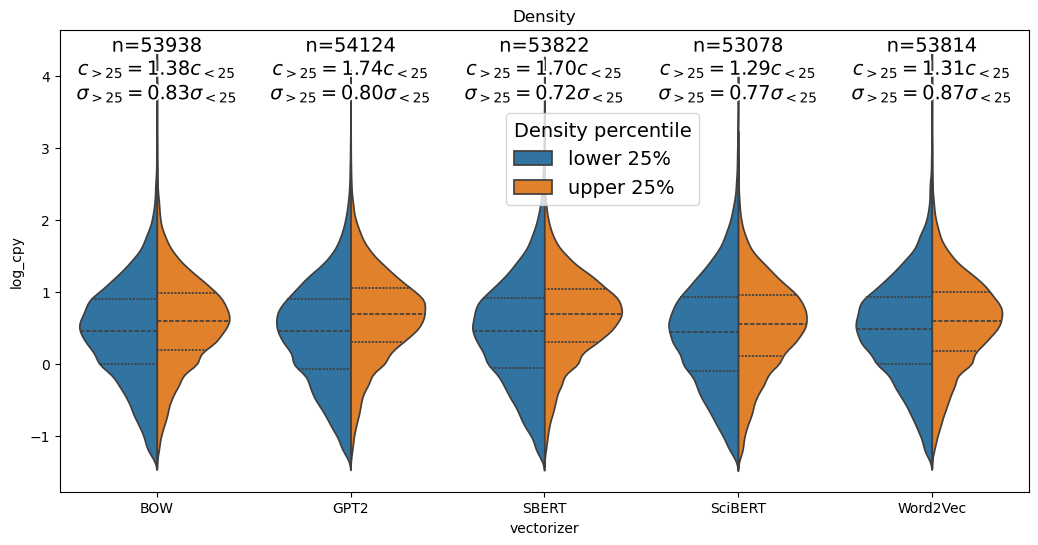

In [22]:

fig = plt.figure(figsize=(len(vectorizer_names) * 2.5, 6))
ax = plt.gca()
ax.set_title("Density")

sns.violinplot(
    ax=ax,
    data=df_quantiles,
    # x='center',
    x='vectorizer',
    y='log_cpy',
    # y='citations_per_year',
    hue='density_cat',
    # palette='mako',
    split=True,
    inner='quart',
    dodge=True,
    gap=0,
)

df_by_vectorizer = df_quantiles.groupby('vectorizer')
fraction_changes = []
fraction_std_changes = []
for i, key in enumerate(vectorizer_names):

    # Get the group
    df_vectorizer = df_by_vectorizer.get_group(key)
    n = df_vectorizer.shape[0]

    # Median change
    df_vectorizer_by_density = df_vectorizer.groupby('density_cat')
    med_cpy = 10.**df_vectorizer_by_density['log_cpy'].median()
    fraction_change = med_cpy[f'upper {metric_percent}%'] / med_cpy[f'lower {metric_percent}%']
    fraction_changes.append(fraction_change)
    median_change_str = (
        fr'$c_{{>{metric_percent}}} = '
        f'{fraction_change:.2f}'
        fr'c_{{<{metric_percent}}}$'
    )

    # Median change in width
    std_cpy = 10.**df_vectorizer_by_density['log_cpy'].std()
    fraction_std_change =  std_cpy[f'upper {metric_percent}%'] / std_cpy[f'lower {metric_percent}%']
    fraction_std_changes.append(fraction_std_change)
    std_change_str = (
        fr'$\sigma_{{>{metric_percent}}} = '
        f'{fraction_std_change:.2f}'
        fr'\sigma_{{<{metric_percent}}}$'
    )

    text = ax.annotate(
        text=f'n={n}\n' + median_change_str + '\n' + std_change_str,
        xy=(i, 1),
        xycoords=matplotlib.transforms.blended_transform_factory(
            ax.transData,
            ax.transAxes,
        ),
        xytext=(0, -5),
        textcoords='offset points',
        ha='center',
        va='top',
        fontsize=14,
    )
    text.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='w'),
        patheffects.Normal()
    ])

ax.legend(prop=dict(size=14))
legend = ax.get_legend()
legend.set_title('Density percentile', prop=dict(size=14))
legend.set_loc('upper center')
legend.set_bbox_to_anchor((0.56, 0.84))
legend.set_alignment('left')

print(
    f'Median fraction change: {np.median(fraction_changes):.2f}\n'
    f'Median std fraction change: {np.median(fraction_std_changes):.2f}\n'
)